In [1]:
import os
import os.path as pth
import json
import shutil
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
BASE_MODEL_NAME = 'InceptionV3-for-upload'
my_model_base = keras.applications.inception_v3
my_model = my_model_base.InceptionV3

config = {
    'is_zscore':True,
    
    # 'input_shape': (540, 960, 3),
    'aug': {
        'resize': (270, 480),
    },
    # 'input_shape': (224, 360, 3),
    'input_shape': (270, 480, 3),

    'output_activation': 'softmax',
    'num_class': 1049,
    'output_size': 1049,
    
    'conv':{
        'conv_num': (0), # (3,5,3),
        'base_channel': 0, # 4,
        'kernel_size': 0, # 3,
        'padding':'same',
        'stride':'X'
    },
    'pool':{
        'type':'X',
        'size':'X',
        'stride':'X',
        'padding':'same'
    },
    'fc':{
        'fc_num': 0,
     },
    
    'activation':'relu',
    
    'between_type': 'avg',
    
    'is_batchnorm': True,
    'is_dropout': False,
    'dropout_rate': 0.5,
    
    'add_dense':True,
    'dense_size': 1024,
    
    'batch_size': 64, #64,
    'buffer_size': 256, #256,
    'loss': 'CategoricalCrossentropy',
    
    'num_epoch': 10000,
    'learning_rate': 1e-3,
    
    'random_state': 7777
}

In [4]:
image_feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'randmark_id': tf.io.FixedLenFeature([], tf.int64),
    # 'id': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

def map_func(target_record):
    img = target_record['image_raw']
    label = target_record['randmark_id']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    return img, label

def resize_and_crop_func(image, label):
    result_image = tf.image.resize(image, config['aug']['resize'])
    # result_image = tf.image.random_crop(image, size=config['input_shape'], seed=7777)
    return result_image, label

def image_aug_func(image, label):
    pass
    return image, label

def post_process_func(image, label):
    # result_image = result_image / 255
    result_image = my_model_base.preprocess_input(image)
    onehot_label = tf.one_hot(label, depth=config['num_class'])
    return result_image, onehot_label

In [5]:
data_base_path = pth.join('data', 'public')  
os.makedirs(data_base_path, exist_ok=True)

In [6]:
category_csv_name = 'category.csv'
category_json_name = 'category.json'
submission_csv_name = 'sample_submisstion.csv'
train_csv_name = 'train.csv'

# train_zip_name = 'train.zip'
train_tfrecord_name = 'all_train.tfrecords'
train_tfrecord_path = pth.join(data_base_path, train_tfrecord_name)
val_tfrecord_name = 'all_val.tfrecords'
val_tfrecord_path = pth.join(data_base_path, val_tfrecord_name)
# test_zip_name = 'test.zip'
test_tfrecord_name = 'test.tfrecords'
test_tfrecord_path = pth.join(data_base_path, test_tfrecord_name)

In [7]:
train_csv_path = pth.join(data_base_path, train_csv_name)
train_df = pd.read_csv(train_csv_path)
train_dict = {k:v for k, v in train_df.values}

submission_csv_path = pth.join(data_base_path, submission_csv_name)
submission_df = pd.read_csv(submission_csv_path)
# submission_df.head()

category_csv_path = pth.join(data_base_path, category_csv_name)
category_df = pd.read_csv(category_csv_path)
category_dict = {k:v for k, v in category_df.values}
# category_df.head()

In [8]:
train_tfrecord_path

'data/public/all_train.tfrecords'

### Model

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import cv2

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GroupKFold, RepeatedStratifiedKFold
from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import os
import os.path as pth
import shutil
import time
from tqdm import tqdm

import itertools
from itertools import product, combinations

import numpy as np
from PIL import Image

from IPython.display import clear_output

from multiprocessing import Process, Queue
import datetime

import tensorflow.keras as keras

from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv3D, AveragePooling3D, MaxPooling3D, Dropout, \
                                    Concatenate, GlobalMaxPool3D, GlobalAvgPool3D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
from tensorflow.keras import backend as K
from tensorflow.keras.constraints import max_norm

In [10]:
conv_comb_list = []
conv_comb_list += [(0,)]

base_channel_list = [0]

fc_list = [0] # 128, 0

# between_type_list = [None, 'avg', 'max']
between_type_list = ['avg']

batch_size_list = [80]

activation_list = ['relu']

# len(conv_comb_list), conv_comb_list

In [11]:
def build_cnn(config):
    input_layer = Input(shape=config['input_shape'], name='input_layer')
    pret_model = my_model(
        input_tensor=input_layer, include_top=False, weights='imagenet', 
        input_shape=config['input_shape'], pooling=config['between_type'], 
        classes=config['output_size']
    )

    pret_model.trainable = False
    
    x = pret_model.output
    
    if config['between_type'] == None:
        x = Flatten(name='flatten_layer')(x)
        
    if config['is_dropout']:
        x = Dropout(config['dropout_rate'], name='output_dropout')(x)    

    if config['add_dense']:
        x = Dense(config['dense_size'], activation=config['activation'],
                    name='dense_layer')(x)

    x = Dense(config['output_size'], activation=config['output_activation'], 
          name='output_fc')(x)
#     x = Activation(activation=config['output_activation'], name='output_activation')(x)
    model = Model(inputs=input_layer, outputs=x, name='{}'.format(BASE_MODEL_NAME))

    return model

In [13]:
model = build_cnn(config)
for i, layer in enumerate(model.layers):
    print(i, layer.name)
#model.summary(line_length=150)
del model

0 input_layer
1 conv2d_94
2 batch_normalization_94
3 activation_94
4 conv2d_95
5 batch_normalization_95
6 activation_95
7 conv2d_96
8 batch_normalization_96
9 activation_96
10 max_pooling2d_4
11 conv2d_97
12 batch_normalization_97
13 activation_97
14 conv2d_98
15 batch_normalization_98
16 activation_98
17 max_pooling2d_5
18 conv2d_102
19 batch_normalization_102
20 activation_102
21 conv2d_100
22 conv2d_103
23 batch_normalization_100
24 batch_normalization_103
25 activation_100
26 activation_103
27 average_pooling2d_9
28 conv2d_99
29 conv2d_101
30 conv2d_104
31 conv2d_105
32 batch_normalization_99
33 batch_normalization_101
34 batch_normalization_104
35 batch_normalization_105
36 activation_99
37 activation_101
38 activation_104
39 activation_105
40 mixed0
41 conv2d_109
42 batch_normalization_109
43 activation_109
44 conv2d_107
45 conv2d_110
46 batch_normalization_107
47 batch_normalization_110
48 activation_107
49 activation_110
50 average_pooling2d_10
51 conv2d_106
52 conv2d_108
53 co

In [14]:
origin_train_len = len(train_df) / 5 * 4
origin_val_len = len(train_df) / 5 * 1

train_num_steps = int(np.ceil((origin_train_len)/config['batch_size']))
val_num_steps = int(np.ceil((origin_val_len)/config['batch_size']))

print(train_num_steps, val_num_steps)

1102 276


In [15]:
model_base_path = data_base_path
model_checkpoint_path = pth.join(model_base_path, 'checkpoint')

InceptionV3-for-upload_resize_270_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O
Epoch 1/10
882/882 [==============================] - 594s 673ms/step - loss: 3.7521 - acc: 0.3423 - precision: 0.9215 - recall: 0.1515 - auc: 0.8331 - val_loss: 1.9846 - val_acc: 0.5777 - val_precision: 0.8623 - val_recall: 0.3992 - val_auc: 0.9521
Epoch 2/10
882/882 [==============================] - 594s 673ms/step - loss: 1.2665 - acc: 0.7213 - precision: 0.9172 - recall: 0.5977 - auc: 0.9727 - val_loss: 1.1322 - val_acc: 0.7494 - val_precision: 0.9086 - val_recall: 0.6605 - val_auc: 0.9739
Epoch 3/10
882/882 [==============================] - 607s 688ms/step - loss: 0.7955 - acc: 0.8156 - precision: 0.9272 - recall: 0.7478 - auc: 0.9838 - val_loss: 2.5866 - val_acc: 0.5062 - val_precision: 0.5953 - val_recall: 0.4513 - val_auc: 0.9076
Epoch 4/10
882/882 [==============================] - 596s 676ms/step - loss: 0.5840 - acc: 0.8585 - precision: 0.9349 - recall: 0.8133 - auc: 0

Epoch 1/10000
    882/Unknown - 484s 549ms/step - loss: 0.6045 - acc: 0.8531 - precision: 0.9126 - recall: 0.8215 - auc: 0.9858
Epoch 00001: val_loss improved from inf to 0.56570, saving model to data/public/checkpoint/InceptionV3-for-upload_resize_270_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O/000001-0.565697-0.604459.hdf5
882/882 [==============================] - 612s 693ms/step - loss: 0.6045 - acc: 0.8531 - precision: 0.9126 - recall: 0.8215 - auc: 0.9858 - val_loss: 0.5657 - val_acc: 0.8637 - val_precision: 0.9140 - val_recall: 0.8415 - val_auc: 0.9863
Epoch 2/10000
881/882 [============================>.] - ETA: 0s - loss: 0.2105 - acc: 0.9425 - precision: 0.9647 - recall: 0.9282 - auc: 0.9970
Epoch 00002: val_loss did not improve from 0.56570
882/882 [==============================] - 617s 700ms/step - loss: 0.2107 - acc: 0.9425 - precision: 0.9646 - recall: 0.9282 - auc: 0.9970 - val_loss: 0.8398 - val_acc: 0.8112 - val_precision: 0.8547 - val_reca

Epoch 18/10000
881/882 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9917 - precision: 0.9929 - recall: 0.9908 - auc: 0.9997
Epoch 00018: val_loss improved from 0.30344 to 0.29573, saving model to data/public/checkpoint/InceptionV3-for-upload_resize_270_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O/000018-0.295733-0.027836.hdf5
882/882 [==============================] - 609s 690ms/step - loss: 0.0278 - acc: 0.9917 - precision: 0.9929 - recall: 0.9908 - auc: 0.9997 - val_loss: 0.2957 - val_acc: 0.9485 - val_precision: 0.9569 - val_recall: 0.9458 - val_auc: 0.9900
Epoch 19/10000
881/882 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9911 - precision: 0.9923 - recall: 0.9901 - auc: 0.9996
Epoch 00019: val_loss improved from 0.29573 to 0.29271, saving model to data/public/checkpoint/InceptionV3-for-upload_resize_270_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O/000019-0.292710-0.030245.hdf5
882/882

Epoch 35/10000
881/882 [============================>.] - ETA: 0s - loss: 0.0166 - acc: 0.9955 - precision: 0.9960 - recall: 0.9951 - auc: 0.9997
Epoch 00035: val_loss did not improve from 0.27666
882/882 [==============================] - 617s 700ms/step - loss: 0.0169 - acc: 0.9955 - precision: 0.9960 - recall: 0.9951 - auc: 0.9997 - val_loss: 0.2882 - val_acc: 0.9522 - val_precision: 0.9588 - val_recall: 0.9494 - val_auc: 0.9905
Epoch 36/10000
881/882 [============================>.] - ETA: 0s - loss: 0.0189 - acc: 0.9951 - precision: 0.9957 - recall: 0.9947 - auc: 0.9997
Epoch 00036: val_loss improved from 0.27666 to 0.27089, saving model to data/public/checkpoint/InceptionV3-for-upload_resize_270_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O/000036-0.270890-0.018945.hdf5
882/882 [==============================] - 609s 690ms/step - loss: 0.0189 - acc: 0.9951 - precision: 0.9957 - recall: 0.9947 - auc: 0.9997 - val_loss: 0.2709 - val_acc: 0.9532 - val_preci

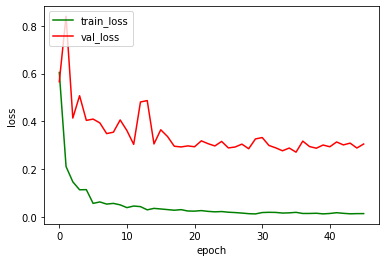

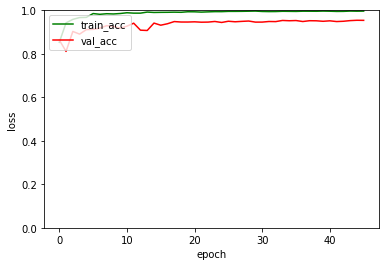

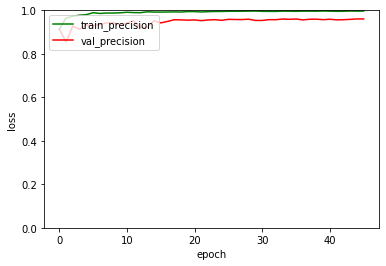

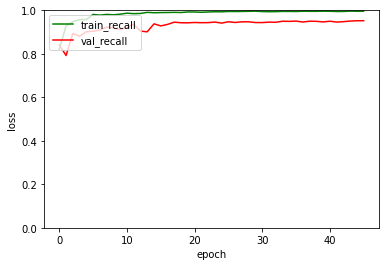

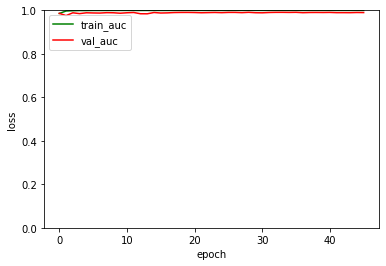

In [16]:
for conv_comb, activation, base_channel, \
    between_type, fc_num, batch_size \
        in itertools.product(conv_comb_list, activation_list,
                              base_channel_list, between_type_list, fc_list,
                              batch_size_list):
    config['conv']['conv_num'] = conv_comb
    config['conv']['base_channel'] = base_channel
    config['activation'] = activation
    config['between_type'] = between_type
    config['fc']['fc_num'] = fc_num
    config['batch_size'] = batch_size

    base = BASE_MODEL_NAME

    base += '_resize_{}'.format(config['aug']['resize'][0])

    base += '_conv_{}'.format('-'.join(map(lambda x:str(x),config['conv']['conv_num'])))
    base += '_basech_{}'.format(config['conv']['base_channel'])
    base += '_act_{}'.format(config['activation'])
    base += '_pool_{}'.format(config['pool']['type'])
    base += '_betw_{}'.format(config['between_type'])
    base += '_fc_{}'.format(config['fc']['fc_num'])
    base += '_zscore_{}'.format(config['is_zscore'])
    base += '_batch_{}'.format(config['batch_size'])
    if config['is_dropout']:
        base += '_DO_'+str(config['dropout_rate']).replace('.', '')
    if config['is_batchnorm']:
        base += '_BN'+'_O'
    else:
        base += '_BN'+'_X'

    model_name = base
    print(model_name)

    ### Define dataset
    dataset = tf.data.TFRecordDataset(train_tfrecord_path, compression_type='GZIP')
    dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # dataset = dataset.cache()
    dataset = dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(resize_and_crop_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(image_aug_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(config['buffer_size'])
    dataset = dataset.batch(config['batch_size'])
    dataset = dataset.map(post_process_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    val_dataset = tf.data.TFRecordDataset(val_tfrecord_path, compression_type='GZIP')
    val_dataset = val_dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.map(resize_and_crop_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # val_dataset = val_dataset.map(image_aug_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # val_dataset = val_dataset.shuffle(config['buffer_size'])
    val_dataset = val_dataset.batch(config['batch_size'])
    val_dataset = val_dataset.map(post_process_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # val_dataset = val_dataset.cache()
    val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    model_path = pth.join(
        model_checkpoint_path, model_name, 
    )
    model = build_cnn(config)
    #         model.summary()
    
    initial_epoch = 0

    if pth.isdir(model_path) and len([_ for _ in os.listdir(model_path) if _.endswith('hdf5')]) >= 1:
        model.compile(loss=config['loss'], optimizer=Adam(lr=config['learning_rate']),
                  metrics=['acc', 'Precision', 'Recall', 'AUC'])
        
        model_chk_name = sorted(os.listdir(model_path))[-1]
        initial_epoch = int(model_chk_name.split('-')[0])
        model.load_weights(pth.join(model_path, model_chk_name))
    else:
        # first: train only the top layers (which were randomly initialized)
        # i.e. freeze all convolutional InceptionV3 layers
        model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                     metrics=['acc', 'Precision', 'Recall', 'AUC'])
        
        model.fit(
            x=dataset, epochs=10, # train only top layers for just a few epochs.
            validation_data=val_dataset, shuffle=True,
            #callbacks = [checkpointer, es], #batch_size=config['batch_size']
            initial_epoch=initial_epoch,
            # steps_per_epoch=train_num_steps, validation_steps=val_num_steps,
            verbose=1)
        
        # at this point, the top layers are well trained and we can start fine-tuning
        # convolutional layers from inception V3. We will freeze the bottom N layers
        # and train the remaining top layers.
        
        # let's visualize layer names and layer indices to see how many layers
        # we should freeze:
        for i, layer in enumerate(model.layers):
           print(i, layer.name)
        
        # we chose to train the top 2 inception blocks, i.e. we will freeze
        # the first 249 layers and unfreeze the rest:
        for layer in model.layers[:229]:  # [:249]:
           layer.trainable = False
        for layer in model.layers[229:]:  # [249:]:
           layer.trainable = True
        
        # we need to recompile the model for these modifications to take effect
        # we use Adam with a low learning rate
        model.compile(loss=config['loss'], optimizer=Adam(lr=config['learning_rate']),
            metrics=['acc', 'Precision', 'Recall', 'AUC'])

        
    # IGNORE 4 lines below in InceptionV3 
    # ### Freeze first layer
    # conv_list = [layer for layer in model.layers if isinstance(layer, keras.layers.Conv2D)]
    # conv_list[0].trainable = False
    # # conv_list[1].trainable = False

    os.makedirs(model_path, exist_ok=True)
    model_filename = pth.join(model_path, '{epoch:06d}-{val_loss:0.6f}-{loss:0.6f}.hdf5')
    checkpointer = ModelCheckpoint(
        filepath=model_filename, verbose=1, 
        period=1, save_best_only=True, 
        monitor='val_loss'
    )
    es = EarlyStopping(monitor='val_loss', verbose=1, patience=10)

    hist = model.fit(
        x=dataset, epochs=config['num_epoch'], 
        validation_data=val_dataset, shuffle=True,
        callbacks = [checkpointer, es], #batch_size=config['batch_size']
        initial_epoch=initial_epoch,
        # steps_per_epoch=train_num_steps, validation_steps=val_num_steps,
        verbose=1
    )

    model_analysis_path = model_path.replace('checkpoint', 'analysis')
    visualization_path = pth.join(model_analysis_path,'visualization')
    os.makedirs(visualization_path, exist_ok=True)
    
    print()
    # clear_output()        
    for each_label in ['loss', 'acc', 'precision', 'recall', 'auc']:
        fig, ax = plt.subplots()
        ax.plot(hist.history[each_label], 'g', label='train_{}'.format(each_label))
        ax.plot(hist.history['val_{}'.format(each_label)], 'r', label='val_{}'.format(each_label))
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(loc='upper left')
        if not each_label == 'loss':
            plt.ylim(0, 1)
        plt.show()
        filename = 'learning_curve_{}'.format(each_label)
#             fig.savefig(pth.join(visualization_path, filename), transparent=True)
        plt.cla()
        plt.clf()
        plt.close('all')

    np.savez_compressed(pth.join(visualization_path, 'learning_curve'), 
                        loss=hist.history['loss'], 
                        val_loss=hist.history['val_loss'],
                        acc=hist.history['acc'], 
                        val_acc=hist.history['val_acc'],
                        precision=hist.history['precision'], 
                        vaval_precisionl_mae=hist.history['val_precision'],  
                        recall=hist.history['recall'],
                        val_recall=hist.history['val_recall'],
                        auc=hist.history['auc'],
                        val_auc=hist.history['val_auc']
                        )

    model.save(pth.join(model_path, '000000_last.hdf5'))
    K.clear_session()
    del(model)
    
    model_analysis_base_path = pth.join(model_base_path, 'analysis', model_name) 
    with open(pth.join(model_analysis_base_path, 'config.json'), 'w') as f:
        json.dump(config, f)

    chk_name_list = sorted([name for name in os.listdir(model_path) if name != '000000_last.hdf5'])
    for chk_name in chk_name_list[:-2]:
        os.remove(pth.join(model_path, chk_name))
    # clear_output()

### Inference

In [17]:
image_feature_description_for_test = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    # 'randmark_id': tf.io.FixedLenFeature([], tf.int64),
    # 'id': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function_for_test(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description_for_test)

def map_func_for_test(target_record):
    img = target_record['image_raw']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    return img

def resize_and_crop_func_for_test(image):
    result_image = tf.image.resize(image, config['aug']['resize'])
    # result_image = tf.image.random_crop(image, size=config['input_shape'], seed=7777)
    return result_image

def post_process_func_for_test(image):
    # result_image = result_image / 255
    result_image = my_model_base.preprocess_input(image)
    return result_image

In [18]:
submission_base_path = pth.join(data_base_path, 'submission')
os.makedirs(submission_base_path, exist_ok=True)

In [19]:
for conv_comb, activation, base_channel, \
    between_type, fc_num, batch_size \
        in itertools.product(conv_comb_list, activation_list,
                              base_channel_list, between_type_list, fc_list,
                              batch_size_list):
    config['conv']['conv_num'] = conv_comb
    config['conv']['base_channel'] = base_channel
    config['activation'] = activation
    config['between_type'] = between_type
    config['fc']['fc_num'] = fc_num
    config['batch_size'] = batch_size

    base = BASE_MODEL_NAME

    base += '_resize_{}'.format(config['aug']['resize'][0])

    base += '_conv_{}'.format('-'.join(map(lambda x:str(x),config['conv']['conv_num'])))
    base += '_basech_{}'.format(config['conv']['base_channel'])
    base += '_act_{}'.format(config['activation'])
    base += '_pool_{}'.format(config['pool']['type'])
    base += '_betw_{}'.format(config['between_type'])
    base += '_fc_{}'.format(config['fc']['fc_num'])
    base += '_zscore_{}'.format(config['is_zscore'])
    base += '_batch_{}'.format(config['batch_size'])
    if config['is_dropout']:
        base += '_DO_'+str(config['dropout_rate']).replace('.', '')
    if config['is_batchnorm']:
        base += '_BN'+'_O'
    else:
        base += '_BN'+'_X'

    model_name = base
    print(model_name)

    ### Define dataset
    test_dataset = tf.data.TFRecordDataset(test_tfrecord_path, compression_type='GZIP')
    test_dataset = test_dataset.map(_parse_image_function_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.map(map_func_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.map(resize_and_crop_func_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(config['batch_size'])
    test_dataset = test_dataset.map(post_process_func_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    model_path = pth.join(
        model_checkpoint_path, model_name, 
    )
    model = build_cnn(config)
    #         model.summary()
    model.compile(loss=config['loss'], optimizer=Adam(lr=config['learning_rate']),
                  metrics=['acc', 'Precision', 'Recall', 'AUC'])
    initial_epoch = 0

    model_chk_name = sorted(os.listdir(model_path))[-1]
    initial_epoch = int(model_chk_name.split('-')[0])
    model.load_weights(pth.join(model_path, model_chk_name))

    preds = model.predict(test_dataset, verbose=1)
    pred_labels = np.argmax(preds, axis=1)
    pred_probs = np.array([pred[indice] for pred, indice in zip(preds, pred_labels)])

    submission_csv_path = pth.join(data_base_path, submission_csv_name)
    submission_df = pd.read_csv(submission_csv_path)

    submission_df['landmark_id'] = pred_labels
    submission_df['conf'] = pred_probs

    today_str = datetime.date.today().strftime('%Y%m%d')
    result_filename = '{}.csv'.format(model_name)
    submission_csv_fileaname = pth.join(submission_base_path, '_'.join([today_str, result_filename]))
    submission_df.to_csv(submission_csv_fileaname, index=False)

InceptionV3-for-upload_resize_270_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O
      2/Unknown - 0s 228ms/stepWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0883s vs `on_predict_batch_end` time: 0.3542s). Check your callbacks.
475/475 [==============================] - 262s 552ms/step
